# Project 4: Regression
**ECE 219**: Large-Scale Data Mining: Models and Algorithms [Winter 2021]

Prof. Vwani Roychowdhury

UCLA, Department of ECE

**Due**: 2021.03.19 11:59PM PT

In [1]:
#!pip install pandas-profiling[notebook]

In [1]:
from pandas_profiling import ProfileReport
from IPython.display import display
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

tqdm.pandas()

C:\Users\sriva\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Q 10 - 20

scoring in recursive feature selection

Data-loading and pre-processing

In [9]:
BIKE_SHARING_DATA = "C:\\Work\\UCLA\\Winter 2021\\219 Large Scale Data Mining Models and Algorithms\\Project_4\\Bike-Sharing-Dataset\\day.csv"
SUICIDE_DATA = "C:\\Work\\UCLA\\Winter 2021\\219 Large Scale Data Mining Models and Algorithms\\Project_4\\archive\\master.csv"
VIDEO_TRANSCODING_DATA = "C:\\Work\\UCLA\\Winter 2021\\219 Large Scale Data Mining Models and Algorithms\\Project_4\\online_video_dataset\\transcoding_mesurment.tsv"

In [10]:
Ys_bik = ['cnt']
df_bik = pd.read_csv(BIKE_SHARING_DATA)
df_bik.drop(columns=['instant', 'dteday','casual', 'registered'], inplace=True)

In [11]:
Xs_sui = [
    'country', 
    'year', 
    'sex', 
    'age', 
    'population', 
    ' gdp_for_year ($) ',
    'gdp_per_capita ($)',
    'generation'
]
Ys_sui = ['suicides/100k pop']
df_sui = pd.read_csv(SUICIDE_DATA, usecols=Xs_sui+Ys_sui)
df_sui.reset_index(drop=True, inplace=True)
df_sui.columns = [col.strip() for col in df_sui.columns]
Xs_sui = [col.strip() for col in Xs_sui]
df_sui['gdp_for_year ($)'] = df_sui['gdp_for_year ($)'].map(lambda x: int(x.replace(',', "")))
df_sui.dtypes

country                object
year                    int64
sex                    object
age                    object
population              int64
suicides/100k pop     float64
gdp_for_year ($)        int64
gdp_per_capita ($)      int64
generation             object
dtype: object

In [12]:
Ys_vid = ['utime']
df_vid = pd.read_csv(VIDEO_TRANSCODING_DATA, sep='\t')
df_vid.drop(columns=['id', 'b_size'], inplace=True)
df_vid.dtypes

duration       float64
codec           object
width            int64
height           int64
bitrate          int64
framerate      float64
i                int64
p                int64
b                int64
frames           int64
i_size           int64
p_size           int64
size             int64
o_codec         object
o_bitrate        int64
o_framerate    float64
o_width          int64
o_height         int64
umem             int64
utime          float64
dtype: object

In [13]:
dfs = [df_bik, df_sui, df_vid]
Ys = [Ys_bik, Ys_sui, Ys_vid]

datasets = ['Bike Sharing', 'Suicide', 'Video Transcoding']
colors = ['blue', 'red', 'green']

#### Changing countries to continents in df_sui

In [16]:
import pycountry_convert as pc
import country_converter as coco

In [17]:
def country2continent(country_name):
    try:
        country_code = coco.convert(names=country_name, to='ISO2') # alpha2 == ISO2
        return pc.country_alpha2_to_continent_code(country_code)
    except:
        return "N/A"

In [18]:
df_sui['continent'] = df_sui['country'].progress_apply(lambda x: country2continent(x))

In [19]:
df_sui = df_sui.drop(columns=['country'])

In [23]:
def normalize_df(df, columns):
    df[columns] = (df[columns]-df[columns].mean())/df[columns].std()
    return df

In [24]:
norm_bik = ['temp','atemp', 'hum', 'windspeed']
df_bik = normalize_df(df_bik, norm_bik)

In [25]:
norm_sui = ['population', 'gdp_for_year ($)', 'gdp_per_capita ($)']
df_sui = normalize_df(df_sui, norm_sui)

In [26]:
norm_vid = [
    'duration', 
    'width', 
    'height', 
    'bitrate', 
    'framerate', 
    'i', 
    'p', 
    'frames', 
    'i_size',
    'p_size',
    'size',
    'o_bitrate',
    'o_framerate',
    'o_width',
    'o_height'   
]
df_vid = normalize_df(df_vid, norm_vid)

In [107]:
norm_names = [norm_bik, norm_sui, norm_vid]

In [27]:
df_bik.to_csv('C:\\Work\\UCLA\\Winter 2021\\219 Large Scale Data Mining Models and Algorithms\\Project_4\\Bike-Sharing-Dataset\\df_bik.csv', index=False)
df_sui.to_csv('C:\\Work\\UCLA\\Winter 2021\\219 Large Scale Data Mining Models and Algorithms\\Project_4\\archive\\df_sui.csv', index=False)
df_vid.to_csv('C:\\Work\\UCLA\\Winter 2021\\219 Large Scale Data Mining Models and Algorithms\\Project_4\\online_video_dataset\\df_vid.csv', index=False)

In [72]:
df_vid = df_vid.drop(columns=['umem'])

In [80]:
y_bik = 'cnt'
y_sui = 'suicides/100k pop'
y_vid = 'utime'
ys = [y_bik, y_sui, y_vid]

In [90]:
dfs = [df_bik, df_sui, df_vid]

In [108]:
cat_bik = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
cat_bik_mask = np.array([1,1,1,1,1,1,1,0,0,0,0])

cat_sui = ['year', 'sex', 'age', 'generation','continent']
cat_sui_mask = np.array([1,1,1,0,0,0,1,1])

cat_vid = ['codec', 'o_codec']
cat_vid_mask = np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0])

cat_masks = [cat_bik_mask, cat_sui_mask, cat_vid_mask]
cat_names = [cat_bik, cat_sui, cat_vid]

In [92]:
#To see the names of categorical features
for d, df, y, cmask in zip(datasets, dfs, ys, cat_masks):
    print(d)
    X = df.drop(columns=y)
    print(X.columns[cmask == 1])

Bike Sharing
Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit'],
      dtype='object')
Suicide
Index(['year', 'sex', 'age', 'generation', 'continent'], dtype='object')
Video Transcoding
Index(['codec', 'o_codec'], dtype='object')


In [ ]:
def convert_categorical(df, cols):
    for c in cols:
        df[c] = pd.Categorical(df[c])
    return df

In [94]:
df_bik = convert_categorical(df_bik, cat_bik)
df_sui = convert_categorical(df_sui, cat_sui)
df_vid = convert_categorical(df_vid, cat_vid)

In [95]:
dfs = [df_bik, df_sui, df_vid]

### Feature selection

In [28]:
from sklearn.preprocessing import OrdinalEncoder

In [39]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression

In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
#from sklearn.linear_model import RidgeCV
#from sklearn.linear_model import LassoCV

In [144]:
from sklearn.metrics import SCORERS
from sklearn.model_selection import KFold

Scalar encoding the categorical features before computing F scores and MI

In [103]:
def enc_df(df, cat):
    X = df.copy(deep = True)
    enc = OrdinalEncoder()
    enc.fit(X[cat])
    X[cat] = enc.transform(X[cat])
    
    #enc is returned so as to transform any test data, if needed.
    return X, enc

In [104]:
df_bikenc, enc_bik = enc_df(df_bik, cat_bik)
df_suienc, enc_sui = enc_df(df_sui, cat_sui)
df_videnc, enc_vid = enc_df(df_vid, cat_vid)

In [105]:
dfs_enc = [df_bikenc, df_suienc, df_videnc]
obj_enc = [enc_bik, enc_sui, enc_vid]

In [106]:
results = {}

for d, df, y, cmask in zip(datasets, dfs_enc, ys, cat_masks):
    print(d)
    
    X = df.drop(columns=y)
    y = df[y]
      
    # mutual information
    mi = mutual_info_regression(X, y, discrete_features = cmask)
    mi /= np.max(mi)
    
    #fregression
    f_test, _ = f_regression(X,y)
    f_test /= np.max(f_test)
    
    
    df_f = pd.DataFrame(list(zip(df.columns, mi, f_test)), columns=['feature', 'mi','f_reg'])
    
    results[d] = df_f
    
    display(df_f)

Bike Sharing


,feature,mi,f_reg
0,season,0.466051,0.298407
1,yr,0.597241,0.714867
2,mnth,0.803197,0.128519
3,holiday,0.023786,0.007092
4,weekday,0.098602,0.006904
5,workingday,0.049398,0.005673
6,weathersit,0.140899,0.146603
7,temp,0.838615,0.981381
8,atemp,1.000000,1.000000
9,hum,0.097710,0.015467


Suicide


,feature,mi,f_reg
0,year,0.000000,0.008431
1,sex,0.230157,1.000000
2,age,0.465084,0.200661
3,population,1.000000,0.000379
4,suicides/100k pop,0.375577,0.003522
5,gdp_for_year ($),0.323407,0.000018
6,gdp_per_capita ($),0.257465,0.013746
7,generation,0.148086,0.011214


Video Transcoding


,feature,mi,f_reg
0,duration,1.000000,0.000081
1,codec,0.188433,0.000900
2,width,0.429159,0.045465
3,height,0.434882,0.044485
4,bitrate,0.948674,0.065419
5,framerate,0.526289,0.016789
6,i,0.876865,0.000906
7,p,0.958855,0.002925
8,b,0.019529,0.000070
9,frames,0.956641,0.002910


Asumming a cut-off of 0.075, train on the dataset after dropping features that had both MI and Fscore less than 0.075

In [169]:
drop_bik1 = ['holiday', 'workingday']
drop_sui1 = ['year']
drop_vid1 = ['b', 'o_bitrate', 'o_framerate']
drop_feat1 = [drop_bik1, drop_sui1, drop_vid1]

One hot vectorize the categorical features of the dataset

In [114]:
df_bik_oh = pd.get_dummies(df_bik)
df_sui_oh = pd.get_dummies(df_sui)
df_vid_oh = pd.get_dummies(df_vid)

In [117]:
dfs_oh = [df_bik_oh, df_sui_oh, df_vid_oh]

In [120]:
df_bik_oh.columns

Index(['temp', 'atemp', 'hum', 'windspeed', 'cnt', 'season_1', 'season_2',
       'season_3', 'season_4', 'yr_0', 'yr_1', 'mnth_1', 'mnth_2', 'mnth_3',
       'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10',
       'mnth_11', 'mnth_12', 'holiday_0', 'holiday_1', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'workingday_0', 'workingday_1', 'weathersit_1',
       'weathersit_2', 'weathersit_3'],
      dtype='object')

In [150]:
def plot_regression(scores,title):
    plt.plot(-scores['test_score'], label = 'Avg VALID MSE = {:.4f}'.format(np.mean(-scores['test_score'])))
    plt.plot(-scores['train_score'],label = 'Avg TRAIN MSE = {:.4f}'.format(np.mean(-scores['train_score'])))
    plt.ylabel('MSE')
    plt.xlabel('Fold')
    plt.title(title)
    plt.legend()
    plt.show()

In [164]:
def Reg_CV_plot(d, df, Y, drp,alphas, title):
    X = df.drop(columns = [Y] + drp)
    X = pd.get_dummies(X)
    y = df[Y]

    lin_reg = LinearRegression()
    lin_reg_score = cross_validate(lin_reg, X, y, scoring="neg_mean_squared_error", cv=10, return_train_score=True)
    plot_regression(lin_reg_score,d +' Least Squares'+ title)

    rid_scores={}
    las_scores={}
    
    for alpha in alphas:

        rid_reg = Ridge(alpha = alpha)
        rid_scores[str(alpha)] = cross_validate(rid_reg, X, y, scoring="neg_mean_squared_error", cv=10, return_train_score=True)
        plot_regression(rid_scores[str(alpha)],d +' Ridge'+title+' alpha={:0.4f} '.format(alpha))

        las_reg = Lasso(alpha = alpha)
        las_scores[str(alpha)] = cross_validate(las_reg, X, y, scoring="neg_mean_squared_error", cv=10, return_train_score=True)
        plot_regression(las_scores[str(alpha)],d +' Lasso'+title+' alpha={:0.4f} '.format(alpha))

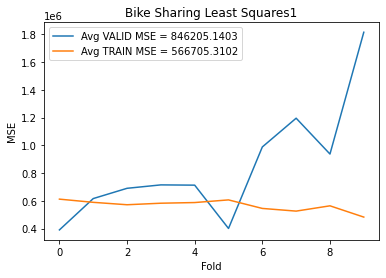

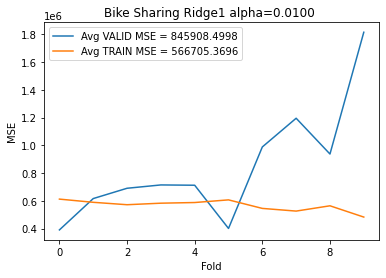

C:\Users\sriva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5472102.451648414, tolerance: 199790.9642304414
  model = cd_fast.enet_coordinate_descent(
C:\Users\sriva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2977169.816419482, tolerance: 255245.10859148938
  model = cd_fast.enet_coordinate_descent(
C:\Users\sriva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2960933.357368827, tolerance: 271504.2992972644
  model = cd_fast.enet_coordinate_descent(
C:\Users\sriva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarni

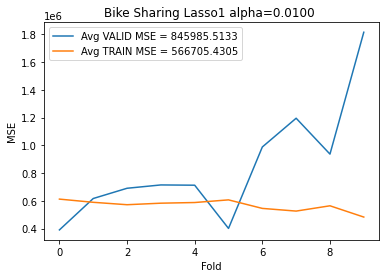

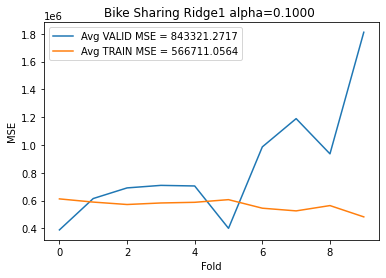

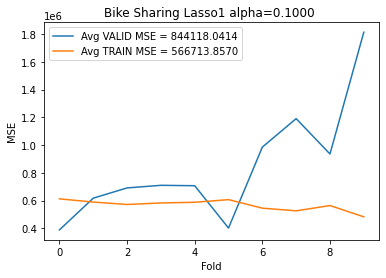

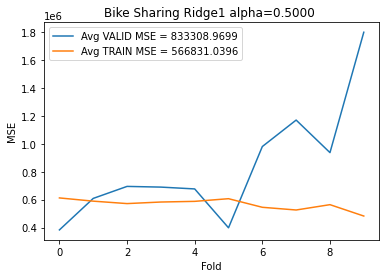

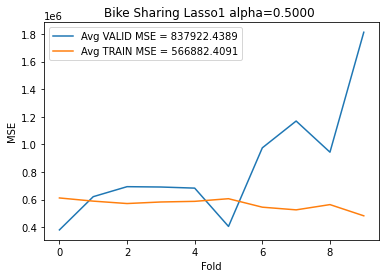

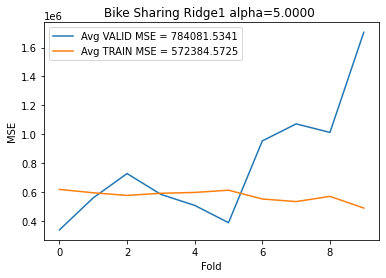

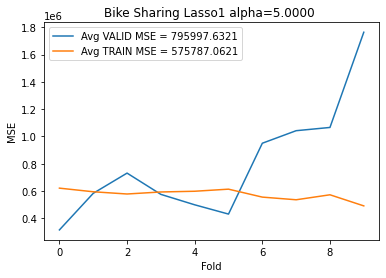

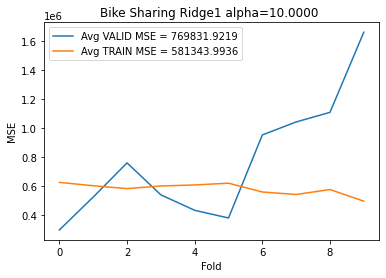

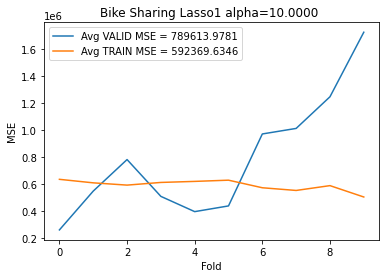

In [165]:
#BIKE dataset
alphas = [0.01,0.1,0.5,5,10]
Reg_CV_plot(datasets[0],df_bik, ys[0], drop_bik1, alphas = alphas, title = "1")

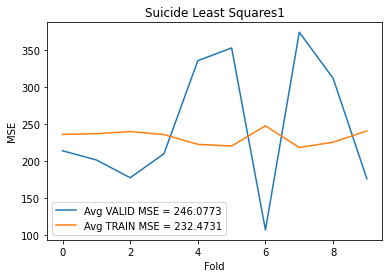

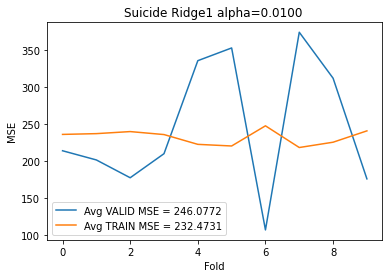

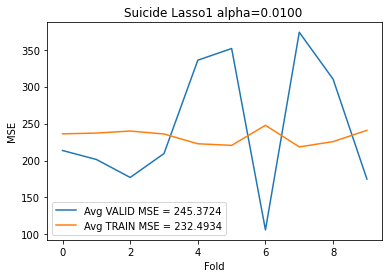

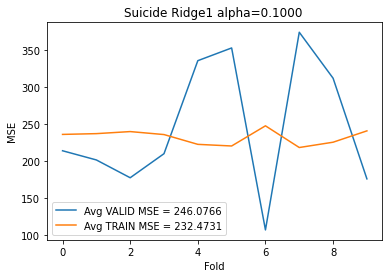

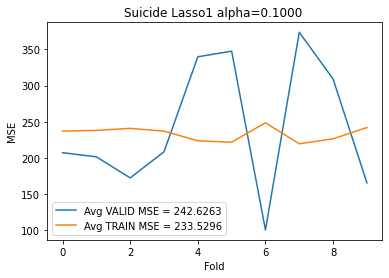

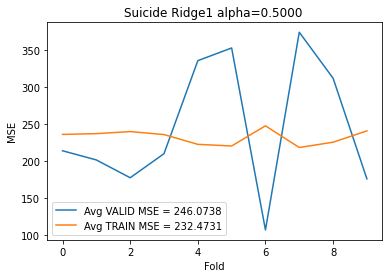

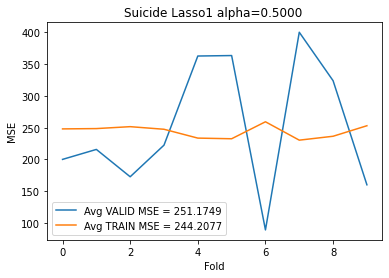

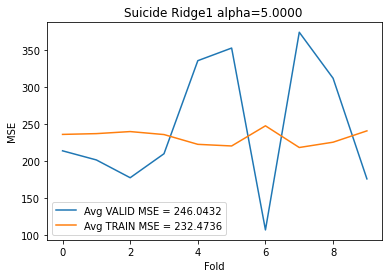

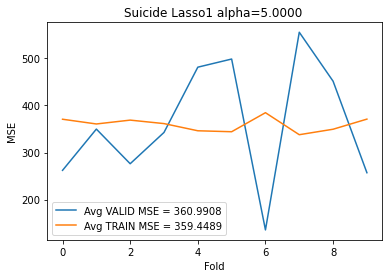

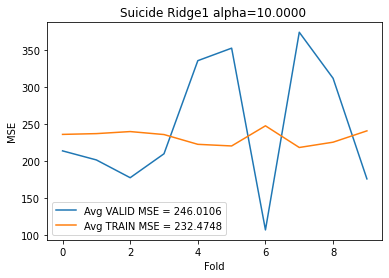

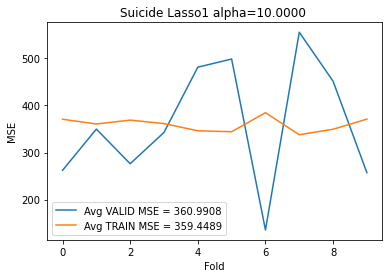

In [166]:
#SUI dataset
alphas = [0.01,0.1,0.5,5,10]
Reg_CV_plot(datasets[1],dfs[1], ys[1], drop_feat1[1], alphas = alphas, title = "1")

In [168]:
dfs[2].columns

Index(['duration', 'codec', 'width', 'height', 'bitrate', 'framerate', 'i',
       'p', 'b', 'frames', 'i_size', 'p_size', 'size', 'o_codec', 'o_bitrate',
       'o_framerate', 'o_width', 'o_height', 'utime'],
      dtype='object')

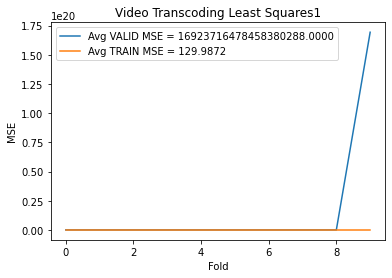

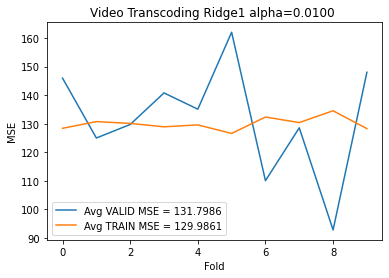

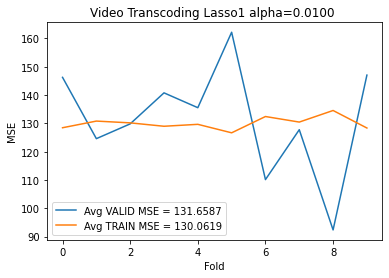

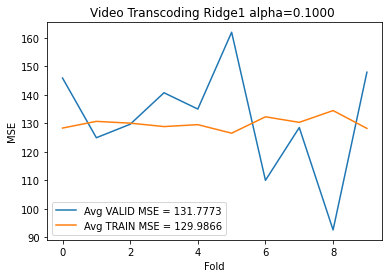

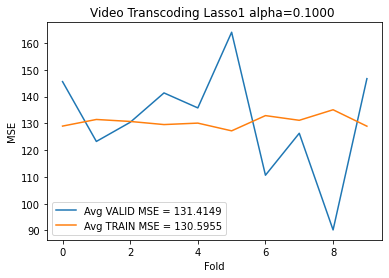

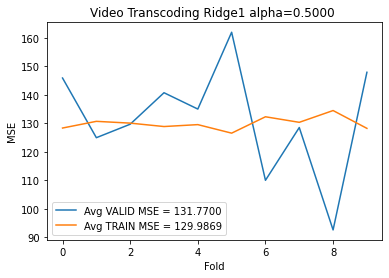

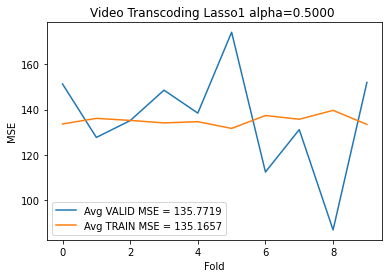

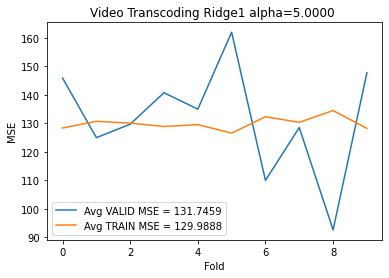

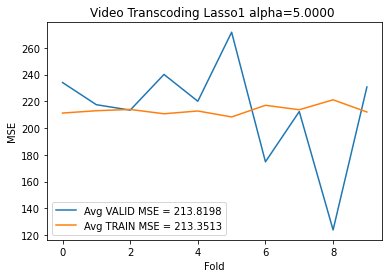

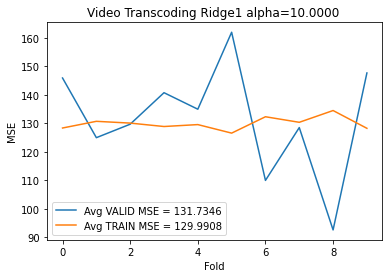

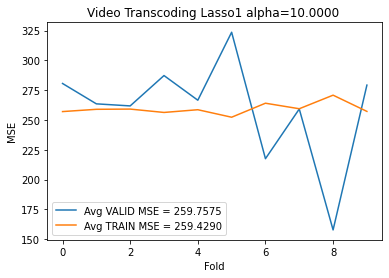

In [170]:
#VID dataset
alphas = [0.01,0.1,0.5,5,10]
Reg_CV_plot(datasets[2],dfs[2], ys[2], drop_feat1[2], alphas = alphas, title = "1")

The above results have to be treated with care, since they include categorical features which were scalar encoded for the purposes of feature selection. Let us remove the categorical features and observe the relationship w.r.t the continuous features.

In [113]:
results_cont = {}

for d, df, y, cnames in zip(datasets, dfs, ys, cat_names):
    print(d)
    
    X = df.drop(columns=[y]+cnames)
    y = df[y]
      
    # mutual information
    mi = mutual_info_regression(X, y)
    mi /= np.max(mi)
    
    #fregression
    f_test, _ = f_regression(X,y)
    f_test /= np.max(f_test)
    
    
    df_f = pd.DataFrame(list(zip(X.columns, mi, f_test)), columns=['Continuous features', 'mi','f_reg'])
    
    results_cont[d] = df_f
    
    display(df_f)

Bike Sharing


,Continuous features,mi,f_reg
0,temp,0.835422,0.981381
1,atemp,1.000000,1.000000
2,hum,0.098610,0.015467
3,windspeed,0.119994,0.087962


Suicide


,Continuous features,mi,f_reg
0,population,1.000000,0.107688
1,gdp_for_year ($),0.375193,1.000000
2,gdp_per_capita ($),0.326856,0.004999


Video Transcoding


,Continuous features,mi,f_reg
0,duration,0.970867,0.000081
1,width,0.454801,0.045465
2,height,0.453099,0.044485
3,bitrate,0.988237,0.065419
4,framerate,0.563534,0.016789
5,i,0.912996,0.000906
6,p,1.000000,0.002925
7,b,0.008250,0.000070
8,frames,0.995844,0.002910
9,i_size,0.975315,0.011146


Let us only drop numeric columns which do not seem to contribute much. Criteria: drop a feature if it has both Fscore and MI less than 0.075

No feature is dropped from BIKE and SUICIDE datasets.

In [172]:
drop_bik2 = []
drop_sui2 = []

drop_vid2 = ['b', 'o_bitrate', 'o_framerate']

drop_feat2 = [drop_bik2, drop_sui2, drop_vid2]

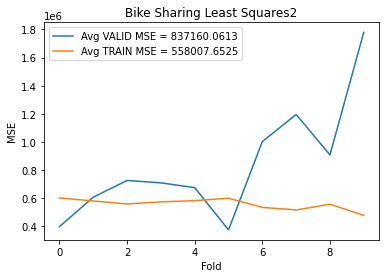

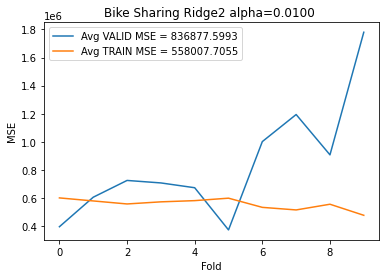

C:\Users\sriva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5377470.921888053, tolerance: 199790.9642304414
  model = cd_fast.enet_coordinate_descent(
C:\Users\sriva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2931357.77234447, tolerance: 255245.10859148938
  model = cd_fast.enet_coordinate_descent(
C:\Users\sriva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5050083.831036925, tolerance: 271504.2992972644
  model = cd_fast.enet_coordinate_descent(
C:\Users\sriva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarnin

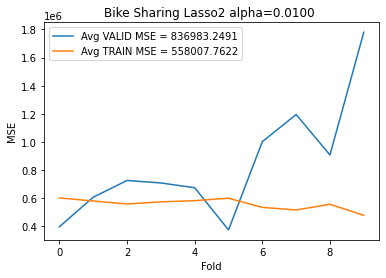

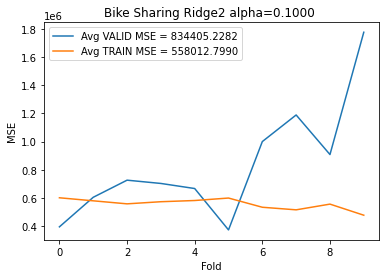

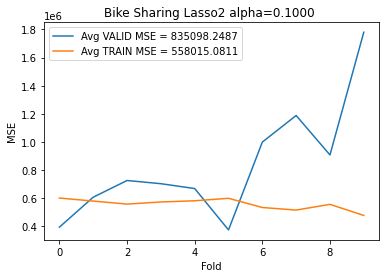

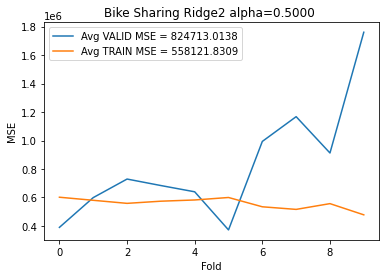

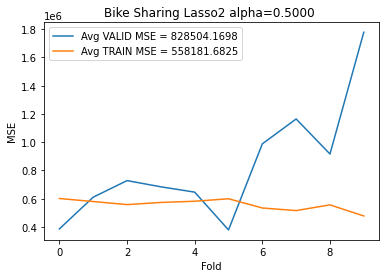

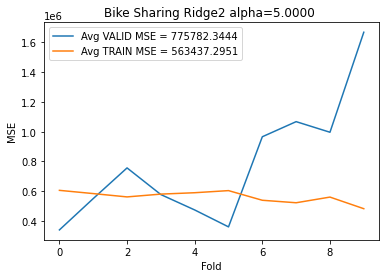

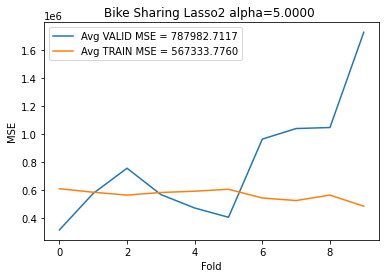

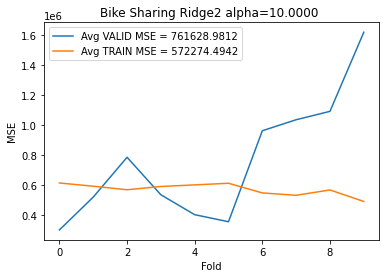

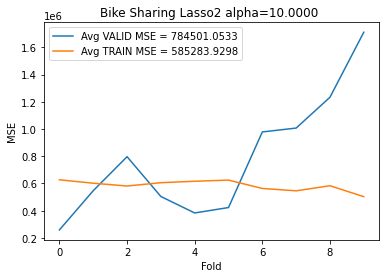

In [173]:
#BIKE dataset
alphas = [0.01,0.1,0.5,5,10]
Reg_CV_plot(datasets[0],dfs[0], ys[0], drop_feat2[0], alphas = alphas, title = "2")

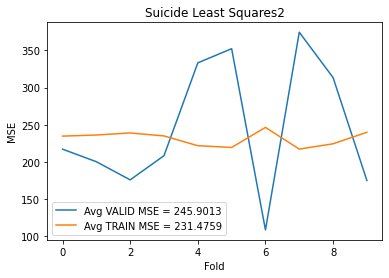

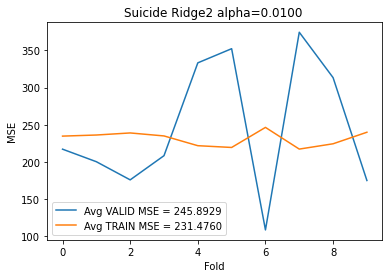

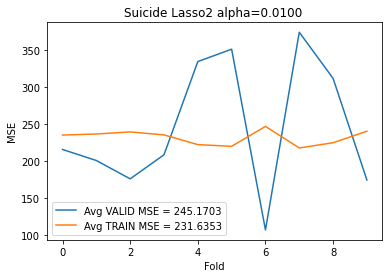

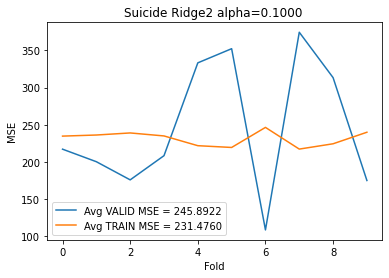

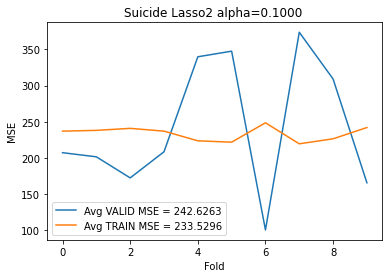

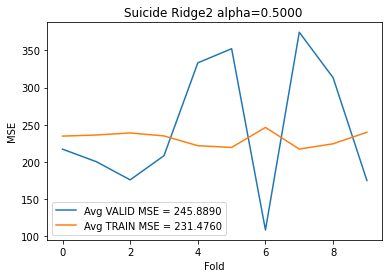

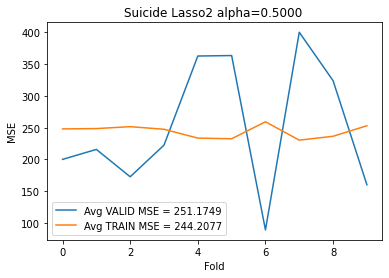

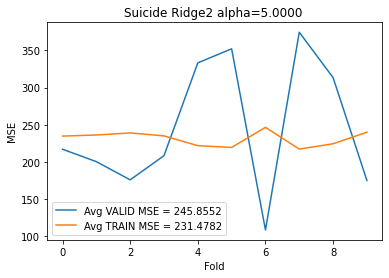

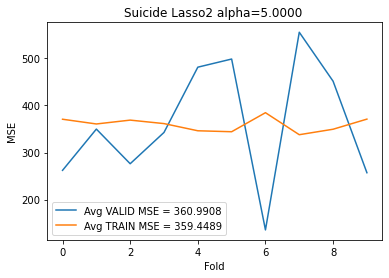

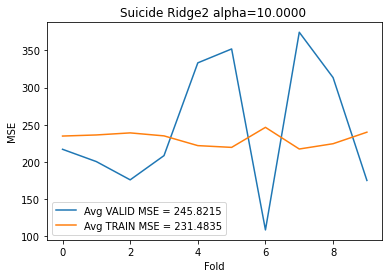

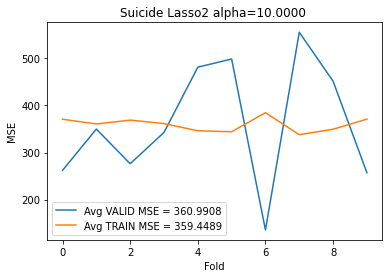

In [174]:
#SUI dataset
alphas = [0.01,0.1,0.5,5,10]
Reg_CV_plot(datasets[1],dfs[1], ys[1], drop_feat2[1], alphas = alphas, title = "2")

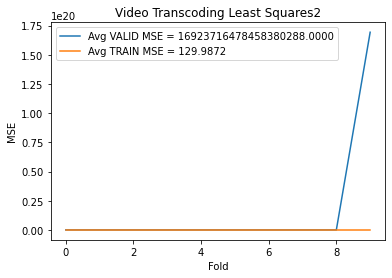

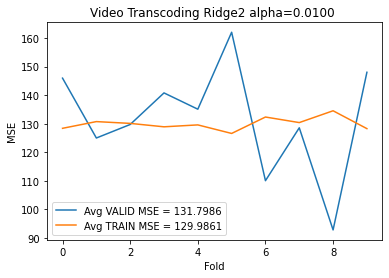

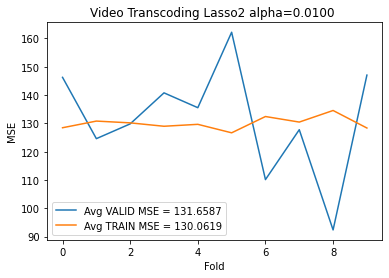

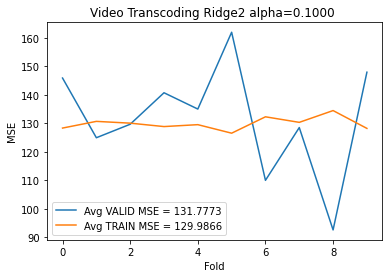

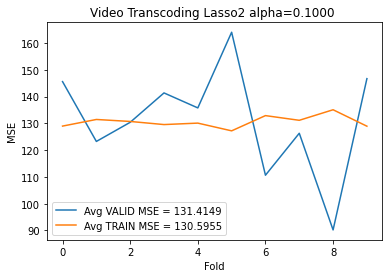

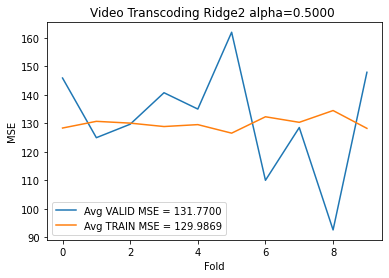

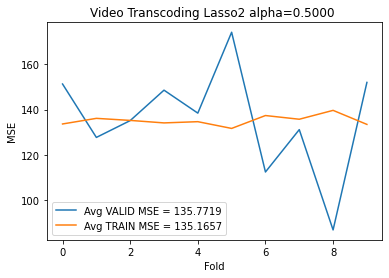

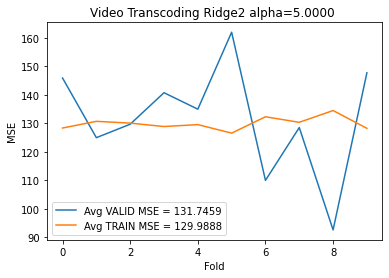

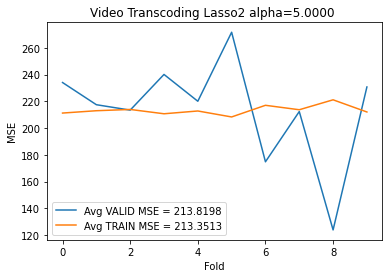

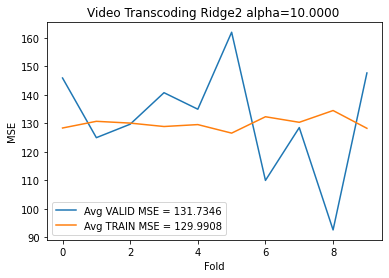

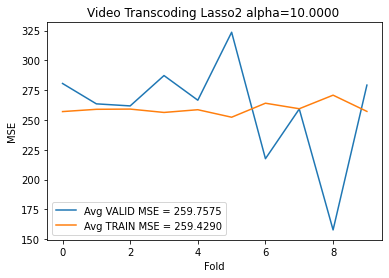

In [175]:
#VID dataset
alphas = [0.01,0.1,0.5,5,10]
Reg_CV_plot(datasets[2],dfs[2], ys[2], drop_feat2[2], alphas = alphas, title = "2")